In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib
from sklearn.datasets import make_moons, make_circles, make_classification

# Datasets


In the first cell, we provide four toy datasets for classification, featuring both linear and non-linear decision frontiers. Using decision trees, random forests, and AdaBoost, we will develop and analyze classifiers capable of handling non-linear decision boundaries.


We also provide in the second cell auxiliary code for plotting the decision boundaries of the trees, called `plot_tree`. 


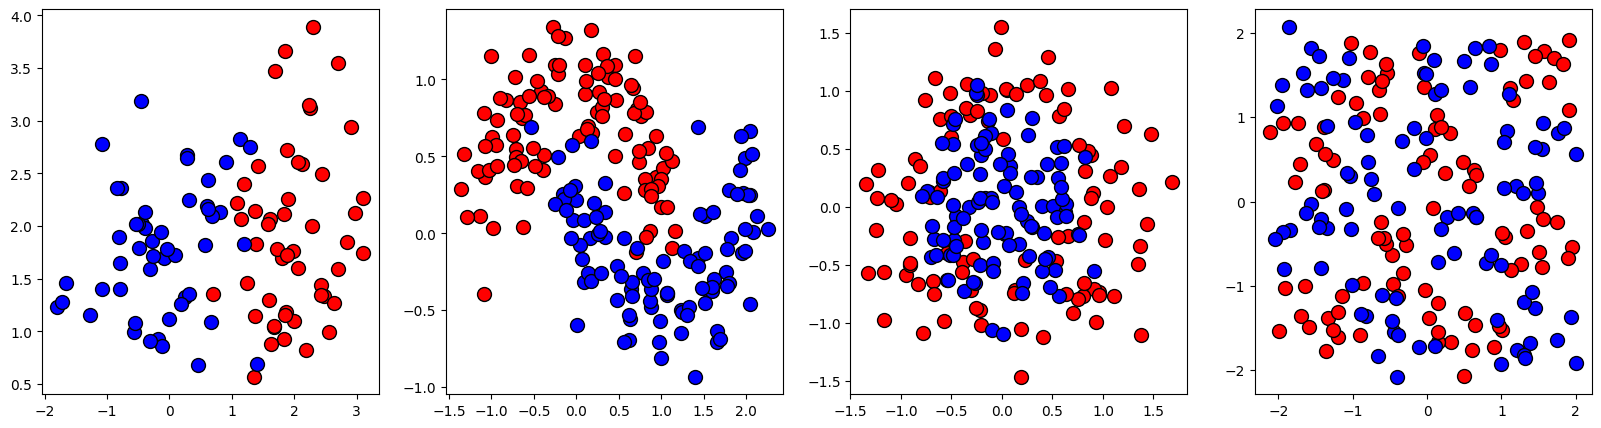

In [35]:
def rand_checkers(n1=100, n2=100, sigma=0.1):
    """ Sample n1 and n2 points from a noisy checker"""
    nbp = int(np.floor(n1 / 8))
    nbn = int(np.floor(n2 / 8))
    xapp = np.reshape(np.random.rand((nbp + nbn) * 16), [(nbp + nbn) * 8, 2])
    yapp = np.ones((nbp + nbn) * 8)
    idx = 0
    for i in range(-2, 2):
        for j in range(-2, 2):
            if (((i + j) % 2) == 0):
                nb = nbp
            else:
                nb = nbn
                yapp[idx:(idx + nb)] = [(i + j) % 2 + 1] * nb
            xapp[idx:(idx + nb), 0] = np.random.rand(nb)
            xapp[idx:(idx + nb), 0] += i + sigma * np.random.randn(nb)
            xapp[idx:(idx + nb), 1] = np.random.rand(nb)
            xapp[idx:(idx + nb), 1] += j + sigma * np.random.randn(nb)
            idx += nb
    ind = np.arange((nbp + nbn) * 8)
    np.random.shuffle(ind)
    res = np.hstack([xapp, yapp[:, np.newaxis]])
    return np.array(res[ind, :2]), np.array(res[ind, 2])-1

plot_colors = "rb"
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)
datasets = [linearly_separable,
            make_moons(n_samples = 200, noise=0.2, random_state=0),
            make_circles(n_samples = 200, noise=0.3, factor=0.5, random_state=1),
            rand_checkers()]
fig, ax = plt.subplots(1, 4, figsize=(20,5))
for fi in range(len(datasets)):
    dataset = datasets[fi]
    X = dataset[0]
    y = dataset[1]
    n_classes = len(np.unique(y))
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        ax[fi].scatter(X[idx, 0], X[idx, 1], c=color, edgecolor='black', s=100)
dataset = datasets[1]

In [92]:
def plot_tree(clf,X,y):
  n_classes = 2
  plot_colors = "br"
  plot_step = 0.02
  plt.figure(figsize=(3,3))   
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                       np.arange(y_min, y_max, plot_step))

  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
  plt.axis("tight")
  # Plot the training points
  for i, color in zip(range(n_classes), plot_colors):
      idx = np.where(y == i)
      plt.scatter(X[idx, 0], X[idx, 1], c=color, alpha=.2)
  plt.show()

# Impurity measures
## Exercises 1, 2, 3 :

$\underline{\text{Impurity measures}}$  
1) For the four datasets, create decision trees using both the Gini and entropy criteria. Plot the score of each tree as a function of max_depth, ranging from 1 to 10.

2) For the best max_depth, plot the decision frontier of the best tree (the one with the highest score) for both impurity measures. Use the provided function plot_tree.

3) Select the best impurity measure and max_depth for dataset 2 (blobs) and compare the decision frontier with that of random forests using only the testing data.


#### Question 1

Decision trees algorithm :

a] Get S a training set

b] Build a root node

c] At the current node, find the best binary separation defined by the split $t$ to be applied to S such that $L(t,S)$ is minimal

d] Associate the chosen operator $t(\hat{j},\hat{s})$ to the current node and split the training data into $S_{\text{left}}$ and $S_{\text{right}}$

e] Build two child nodes, right and left (associated resp. with $S_r$ and $S_l$)

f] & g] Compute a stopping criteria for the right node / left node
    $\rightarrow$ If satisfied, the node becomes a leaf, else we go back to c]


#### Here, the stopping criteria uses the Gini index and cross entropy criteria

Cross entropy : $H(S) = - \sum^C_{k=1} p_k(S)\ln(p_k(S))$

Gini index : $H(S) = \sum^C_{k=1} p_k(S)(1-p_k(S))$

With $p_k(S) = \frac{1}{n}\sum^n_{i=1}\textbf{1}(y_i=k)$

Here, we take $\underline{\text{C = 2}}$ since we only have two class of points.

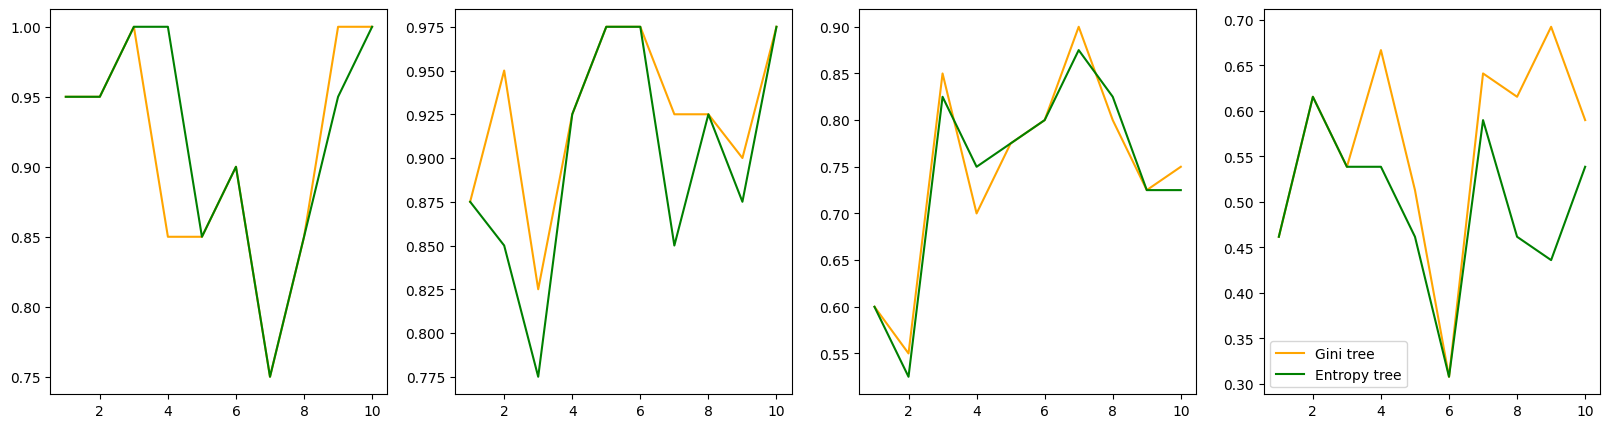

In [83]:
depths = [i for i in range(1,11)] # Depth of the decision tree
eps = 0.0001

def pk_S(k,y):
    result = 0
    n = len(y)
    for i in range (n):
        if y[i] == k:
            result +=1
    if result == 0:
        return(eps)
    return(result/n)

def cross_entropy(y):
    pk_S1 = pk_S(1,y)
    pk_S2 = pk_S(2,y)
    return(-(pk_S1*np.log(pk_S1) + pk_S2*np.log(pk_S2)))

def gini_index(y):
    pk_S1 = pk_S(1,y)
    pk_S2 = pk_S(2,y)
    return(pk_S1*(1- pk_S1) + pk_S2*(1-pk_S2))
# We will not be using my functions since the TA said that it was a waste of time and the scikit functions were better.


def decision_tree(X,y,max_depth):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)
    
    gini_tree = DecisionTreeClassifier(criterion="gini", max_depth = max_depth)
    gini_tree.fit(X_train, y_train)
    gini_result = gini_tree.score(X_test,y_test)
    
    entropy_tree = DecisionTreeClassifier(criterion="entropy", max_depth = max_depth)
    entropy_tree.fit(X_train, y_train)
    entropy_result = entropy_tree.score(X_test,y_test)
    return(gini_result,entropy_result)

fig, ax = plt.subplots(1, 4, figsize=(20,5))
for i in range(len(datasets)):
    dataset = datasets[i]
    X = dataset[0]
    y = dataset[1]
    gini_tree_result = []
    entropy_tree_result = []
    for max_depth in depths:
        gini_result,entropy_result = decision_tree(X,y,max_depth)
        gini_tree_result.append(gini_result)
        entropy_tree_result.append(entropy_result)
    ax[i].plot(depths,gini_tree_result,color = 'orange',label='Gini tree')
    ax[i].plot(depths,entropy_tree_result,color = 'green',label='Entropy tree')
plt.legend()
    

### Question 2]

The best score is the first dataset for max_depth = 3, both for entropy and gini impurity measures.

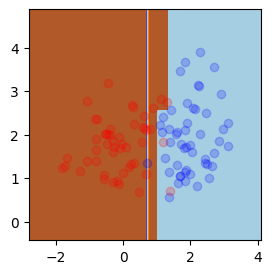

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

dataset = datasets[0]
X = dataset[0]
y = dataset[1]
gini_tree = DecisionTreeClassifier(criterion="gini", max_depth = 3)
gini_tree.fit(X_train, y_train)

plot_tree(gini_tree,X,y)

### Question 3]

The best score for the second dataset is with max_depth = 6, both for entropy and gini impurity measures.

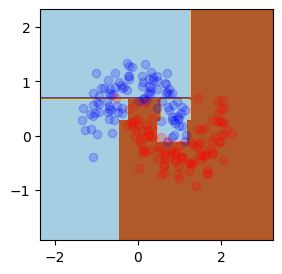

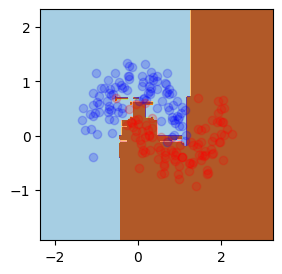

In [95]:
from sklearn.ensemble import RandomForestClassifier

X, y = datasets[1] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
tree_classifier = DecisionTreeClassifier(criterion="gini", max_depth=6)
tree_classifier.fit(X_train, y_train)

random_forest_classifier = RandomForestClassifier(n_estimators=10, max_depth=6)
random_forest_classifier.fit(X_train, y_train)

plot_tree(tree_classifier,X,y)
plot_tree(random_forest_classifier,X,y)

The plot on the top is the tree classifier, and the one on the bottom is the random forest :
We can see that the random frontier looks alike, and is more precise for the random forest classifier than the tree classifier. 

___

# Ensembles
## Exercise 4, random forest

In [97]:
import numpy as np
from sklearn.datasets import  load_diabetes, load_iris, load_digits
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.utils import shuffle

# Load datasets
diabetes = load_diabetes()
iris = load_iris()
digits = load_digits()

# Evaluate on Diabetes dataset (Regression)
X_diabetes, y_diabetes = shuffle(diabetes.data, diabetes.target, random_state=0)
rfr = RandomForestRegressor(random_state=0)
scores_diabetes = cross_val_score(rfr, X_diabetes, y_diabetes, cv=5, scoring='r2')
print(f"Diabetes dataset R² scores: {scores_diabetes}")
print(f"Mean R² score: {np.mean(scores_diabetes):.3f}\n")

# Evaluate on Iris dataset (Classification)
X_iris, y_iris = shuffle(iris.data, iris.target, random_state=0)
classifier_iris = RandomForestClassifier(random_state=0)
scores_iris = cross_val_score(classifier_iris, X_iris, y_iris, cv=5, scoring='accuracy')
print(f"Iris dataset accuracy scores: {scores_iris}")
print(f"Mean accuracy: {np.mean(scores_iris):.3f}\n")

# Evaluate on Digits dataset (Classification)
X_digits, y_digits = shuffle(digits.data, digits.target, random_state=0)
rfc = RandomForestClassifier(random_state=0)
scores_digits = cross_val_score(rfc, X_digits, y_digits, cv=5, scoring='accuracy')
print(f"Digits dataset accuracy scores: {scores_digits}")
print(f"Mean accuracy: {np.mean(scores_digits):.3f}")


Diabetes dataset R² scores: [0.26865182 0.43636315 0.56811725 0.36423771 0.48116661]
Mean R² score: 0.424

Iris dataset accuracy scores: [0.96666667 0.9        1.         1.         0.9       ]
Mean accuracy: 0.953

Digits dataset accuracy scores: [0.97222222 0.97777778 0.98050139 0.9637883  0.97771588]
Mean accuracy: 0.974


## Exercise 5, feature importance

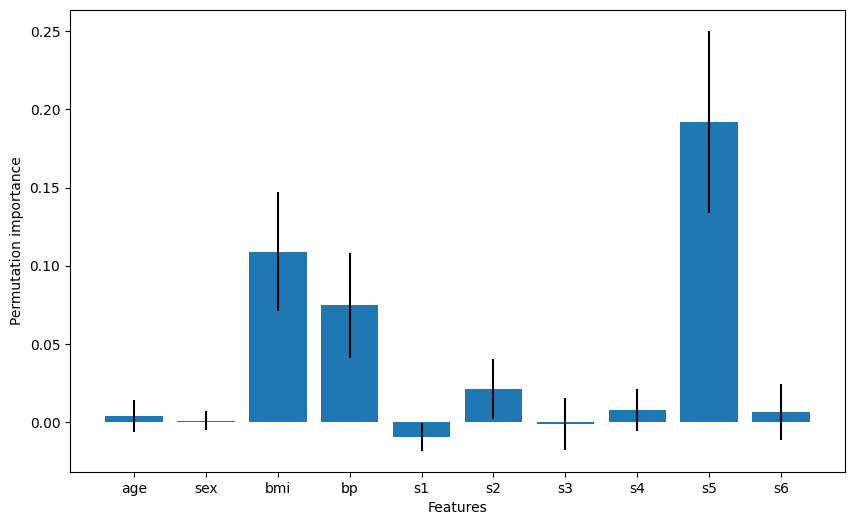

In [103]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Load the Diabetes dataset
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialize and train the Random Forest Regressor
rfr = RandomForestRegressor(random_state=0)
rfr.fit(X_train, y_train)

# Compute the feature importance and plot the results
result = permutation_importance(rfr, X_test, y_test, random_state=0)
importance_mean = result.importances_mean #Mean
importance_std = result.importances_std #Standard Deviation
feature_names = diabetes.feature_names

plt.figure(figsize=(10, 6))
plt.bar(feature_names, importance_mean, yerr=importance_std)
plt.xlabel('Features')
plt.ylabel('Permutation importance')
plt.show()

5] For the diabetes dataset, conduct a feature importance analysis. Among the various techniques available in sklearn, including random forest feature importance and permutation feature importance, select the one covered in class. Plot a bar chart showing the mean and standard deviation of feature importance values and comment on the results.


We can see that the permutation importance has bith high mean and high standard deviation for s5 feature, has low mean and standard deviation for features s1, s2, s4, s6, has a high standard deviation compared to its mean for feature s3.

I'm not sure about interprating about sex, bmi, bp since I don't know those concepts.
The permutation importante for sex and age is really low, but is high for bmi and bp.
___


# Regression
## Exercise 6

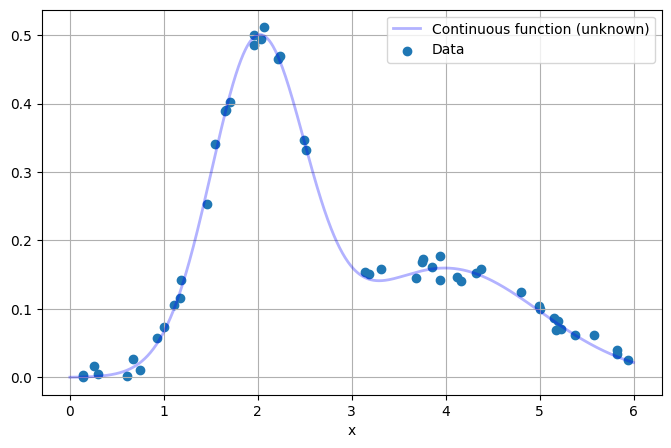

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
mean_1, std_1 = 2, 0.5  
mean_2, std_2 = 4, 1    
weight_1 = 0.6  
weight_2 = 0.4  
x = np.linspace(0, 6, 1000)
pdf_1 = norm.pdf(x, mean_1, std_1)
pdf_2 = norm.pdf(x, mean_2, std_2)
mixture_pdf = weight_1 * pdf_1 + weight_2 * pdf_2
plt.figure(figsize=(8, 5))
plt.plot(x, mixture_pdf, label="Continuous function (unknown)", alpha=.3, color="blue", lw=2)
plt.xlabel("x")
plt.grid(True)
Xr = np.sort(6 * np.random.rand(50))  
pdf_1 = norm.pdf(Xr, mean_1, std_1)
pdf_2 = norm.pdf(Xr, mean_2, std_2)
yr = weight_1 * pdf_1 + weight_2 * pdf_2
yr += np.random.normal(0,.01,len(yr))
plt.scatter(Xr, yr,label="Data")
plt.legend()
plt.show()

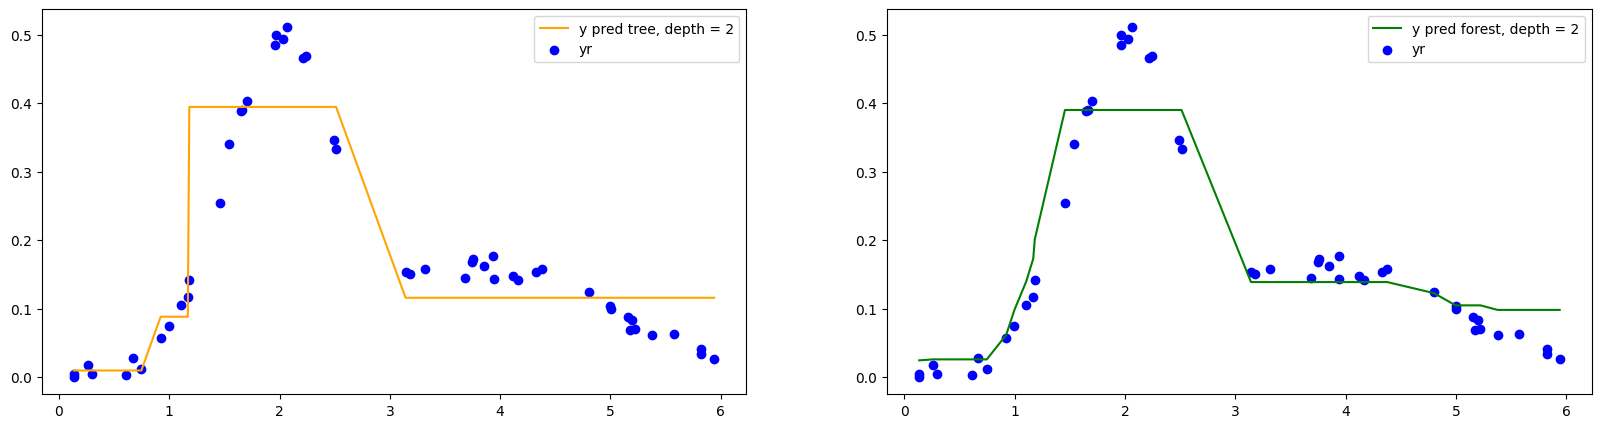

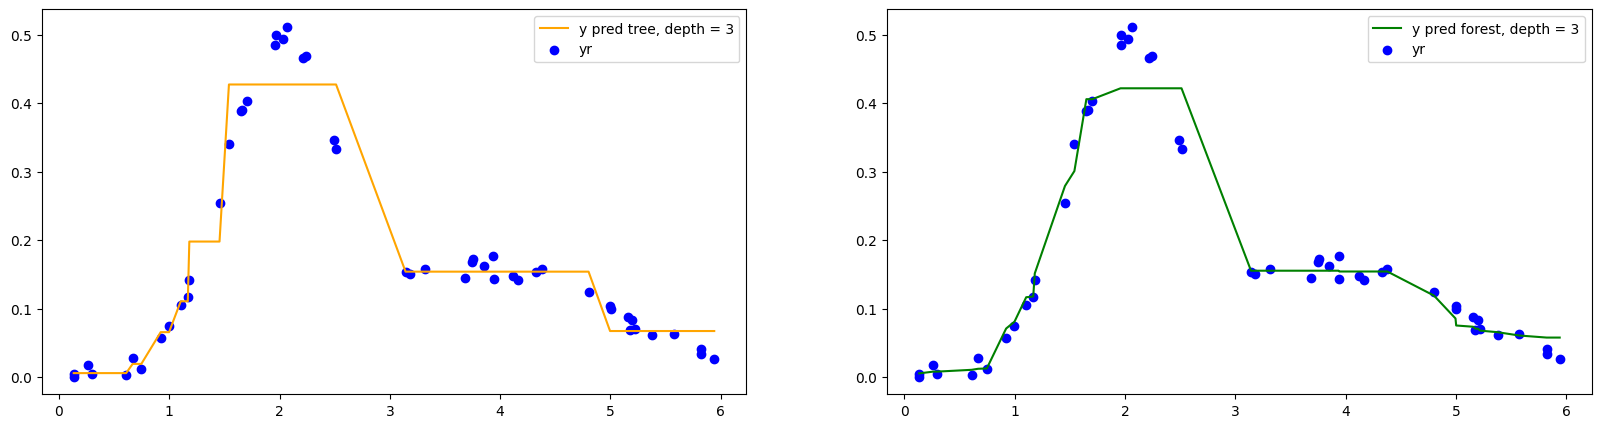

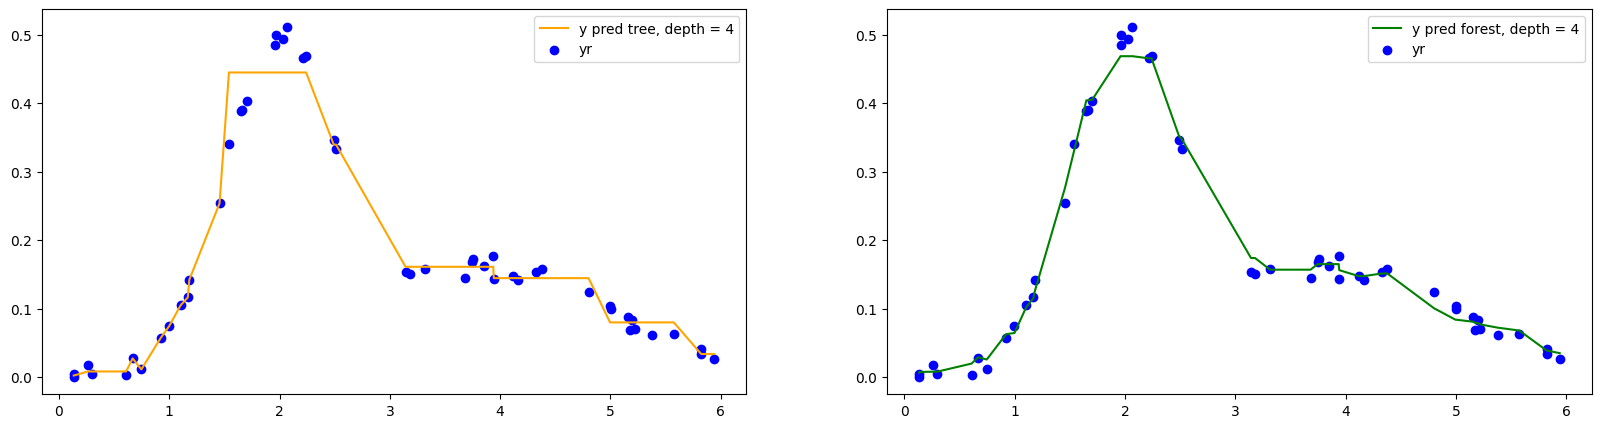

In [124]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

Xr = Xr.reshape(-1,1)

for depth in [2,3,4]:
    tree_regressor = DecisionTreeRegressor(max_depth = depth)
    tree_regressor.fit(Xr, yr)
    random_forest_regressor = RandomForestRegressor(n_estimators = 10, max_depth = depth)
    random_forest_regressor.fit(Xr, yr)
    y_pred_tree = tree_regressor.predict(Xr)
    y_pred_forest = random_forest_regressor.predict(Xr)
    fig, ax = plt.subplots(1, 2, figsize=(20,5))
    ax[0].plot(Xr,y_pred_tree,color = 'orange',label=f'y pred tree, depth = {depth}')
    ax[0].scatter(Xr,yr,color = 'blue',label=f'yr')
    ax[0].legend()
    ax[1].plot(Xr,y_pred_forest,color = 'green',label=f'y pred forest, depth = {depth}')
    ax[1].scatter(Xr,yr,color = 'blue',label=f'yr')
    ax[1].legend()



6] Using the whole dataset, train a regression tree for depths 2, 3, and 4, as well as for a random forest. Plot the prediction and comment on the shape of the predictions. Which impurity criterion is used here ?

The plots are smoother for the random forest with n_generator = 10 but they mostly follow the pattern of yr.
When the depth increases, both the random forest regressor and the tree regressor reach higher the points at around Xr = 2

When we look in the DecisionTreeRegressor class description, we can see that the default criterion used is the $\underline{\text{squared error}}$.
___

___
### I didn't do question 7 nor 13.
___

# AUC ROC - AUC PR

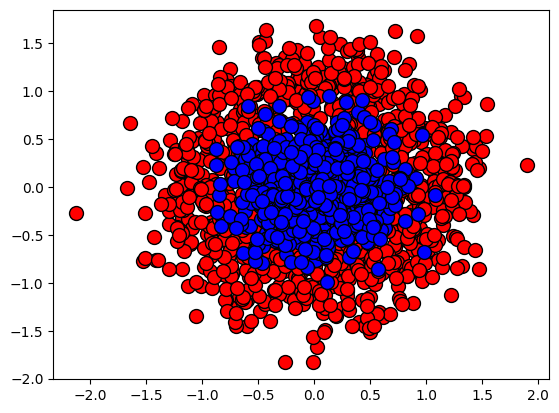

In [191]:
X,y = make_circles(n_samples = 2000, noise=0.3, factor=0.1)
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, edgecolor='black', s=100)

# Notes from the first practice session I took on the lab session 12/03/2025 (shared with Yanis Grigy since we worked together last lab session)

## $\underline{\text{Part 1 : Evaluation metrics for binary classification}}$

### 1. Introducing ROC curves

$\underline{\textit{(1) Recall the definition of Accuracy (and prediction error) using the previous expression}}$

Accuracy = $\frac{\text{TP + TN}}{\text{TP + FP + TN + FN}}$

Error = 1 - Accuracy = $\frac{\text{FP + FN}}{\text{TP + FP + TN + FN}}$

$\underline{\textit{(2) Give at least one example when Accuracy is misleading}}$

We take a data sample with 99% label + and 1% label -
We assign every data point to the + label as a classifier, we get a 99% accuracy

### True Positive Rate (TPR) and False Positive Rate (FPR)

TPR = $\frac{\text{TP}}{\text{TP + FN}}$

FPR = $\frac{\text{FP}}{\text{FP + TN}}$

#### $\underline{\text{AUC ROC : Area Under the Curve - Receiver Operating Characteristic}}$

$\underline{\text{The ROC curve plots FPR on x's axis and TPR on y's axis for different values of threshold } \theta}$

### $\underline{\text{Part 2. Introducing PR curves}}$

##### $\underline{\text{Definitions :}}$

Precision = $\frac{\text{TP}}{\text{TP+FP}}$

Recall = $\frac{\text{TP}}{\text{TP+FN}}$

AUC PR : Area Under the Precision-Recall Curve

AUC PR = 1.0, perfect precision and recall
AUC PR = 0, the model performs poorly

$\underline{\textit{(a) Compare the definitions of Accuracy and Precision}}$

Precision = $\frac{\text{TP}}{\text{TP+FP}}$

Accuracy = $\frac{\text{TP + TN}}{\text{TP + FP + TN + FN}}$

Precision only accounts for correclty classifying the positive class, whereas accuracy accounts for both positive and negative class
___

8] Given the code template, complete the function to compute the average_precision_score and precision_recall_curve from sklearn.metrics. Plot the ROC and PR curves for the balanced dataset.


In [192]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

def plot_roc_pr(proba, y_true):
    # Compute ROC curve and ROC AUC
    fpr, tpr, _ = roc_curve(y_true, proba)
    roc_auc = auc(fpr, tpr)
    
    # Compute Precision-Recall curve and PR AUC
    precision, recall, _ = precision_recall_curve(y_true, proba)
    pr_auc = average_precision_score(y_true, proba)
    
    # Plot ROC Curve
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    
    # Plot PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', lw=2, label=f'PR AUC = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()
    
def subsample_data(X, y, keep_ratio=0.4):
    """Subsample dataset to keep all class 1 and only a fraction of class 0."""
    class_1_mask = y == 0
    class_0_mask = y == 1
    X_class_1 = X[class_1_mask]
    y_class_1 = y[class_1_mask]
    X_class_0 = X[class_0_mask]
    y_class_0 = y[class_0_mask]
    np.random.seed(0)
    sample_indices = np.random.choice(len(X_class_0), int(len(X_class_0) * keep_ratio), replace=False)
    X_class_0 = X_class_0[sample_indices]
    y_class_0 = y_class_0[sample_indices]
    X_subsampled = np.vstack((X_class_1, X_class_0))
    y_subsampled = np.hstack((y_class_1, y_class_0))
    return X_subsampled, y_subsampled


9] Train a random forest with 100 trees on the training split. Use predict_proba to obtain class membership probabilities for the test split.

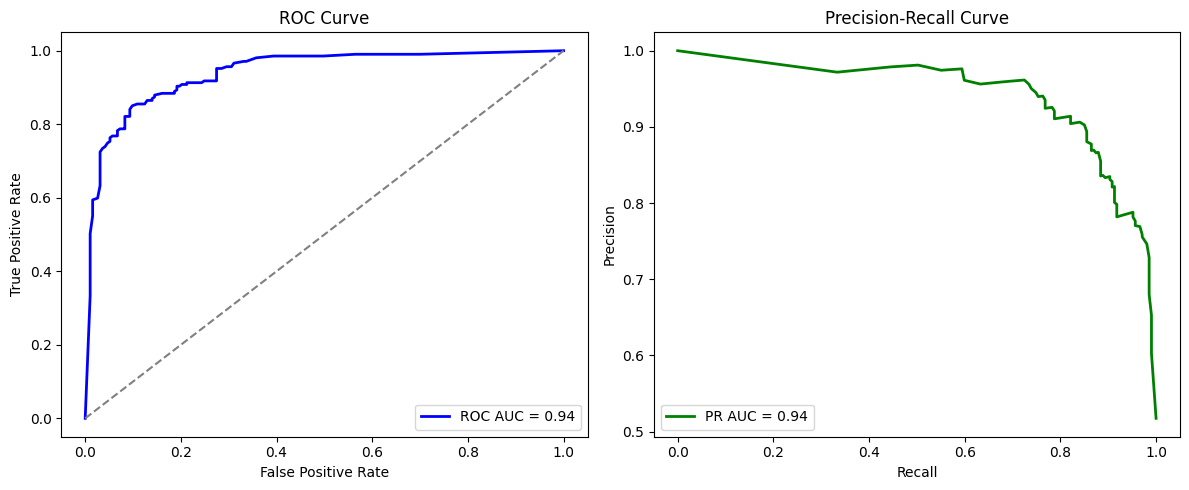

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
random_forest_classifier = RandomForestClassifier(n_estimators=100)
random_forest_classifier.fit(X_train, y_train)
proba = random_forest_classifier.predict_proba(X_test)[:, 1]

plot_roc_pr(proba, y_test)

10] Discard a percentage of the positive data using the subsample_data function provided and plot the ROC and PR curves again. Comment on the differences.

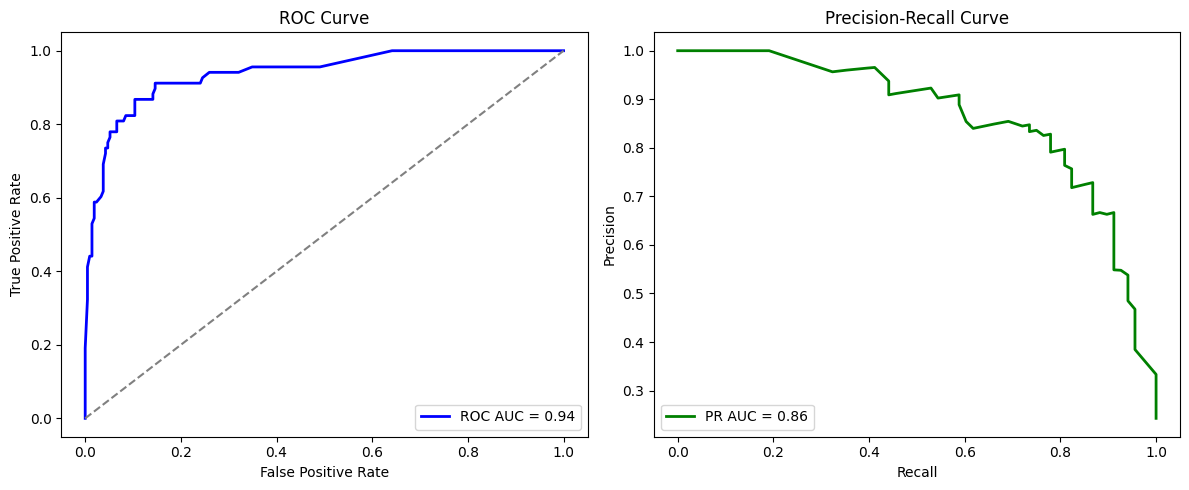

In [200]:
X_sub_sampled, y_sub_sampled = subsample_data(X,y, keep_ratio=0.4)

X_train, X_test, y_train, y_test = train_test_split(X_sub_sampled, y_sub_sampled, test_size=0.2)
random_forest_classifier = RandomForestClassifier(n_estimators=100)
random_forest_classifier.fit(X_train, y_train)
proba = random_forest_classifier.predict_proba(X_test)[:, 1]

plot_roc_pr(proba, y_test)

By discarding a certain amount of the positive data using the subsample data function, we can see that both the ROC curve and PR curve come closer to the middle of the plot (y=x for ROC, y = 1-x for PR) which means that we get closer to the full random choice, which means the precision / accuracy of the model diminishes by removing some positive data samples.

___

11] Express the precision, recall, false positive rate, and true positive rate as conditional probabilities on the true class labels Y and predicted class labels $\hat{Y}$

### True Positive Rate (TPR), False Positive Rate (FPR), Precision and Recall definitions (from the last practice session)

TPR = $\frac{\text{TP}}{\text{TP + FN}}$ = $P(\hat{Y} = 1 | Y = 1)$

FPR = $\frac{\text{FP}}{\text{FP + TN}}$ = $P(\hat{Y} = 1 | Y = 0)$

Precision = $\frac{\text{TP}}{\text{TP+FP}}$ = $P(Y = 1 | \hat{Y} = 1)$

Recall = $\frac{\text{TP}}{\text{TP+FN}}$ = TPR = $P(\hat{Y} = 1 | Y = 1)$ Same definition

We have Precision = $\frac{\text{TP}}{\text{TP+FP}}$

12] Express the F1-score as the harmonic mean of two of the above quantities

$\text{F1-score} = \frac{2}{\frac{1}{\text{Recall}} + \frac{1}{\text{Precision}}}$